In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_in = os.path.join(pth, 'data', 'modeling', 'landscape')
pth_out = os.path.join(pth, 'figures', 'CCCA', 'landscape')

In [3]:
adata_plt = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata_plt = adata_plt[adata_plt.obs.landscape == 'True'].copy()
adata_plt

AnnData object with n_obs × n_vars = 13613 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z', 'Early', 'Late', 'X_mesen1', '

In [4]:
adata = sc.read_h5ad(os.path.join(pth_in, 'CCCA.h5ad'))
adata = adata[adata.obs.landscape == 'True'].copy()
adata

AnnData object with n_obs × n_vars = 8460 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores',

In [5]:
# select developmental landscape
dims = ['X_mesen1', 'X_mesen2']
X_ref = adata_plt.obs[dims].values.copy()
scale = np.ptp(X_ref, axis = 0)
X_ref = X_ref[np.newaxis, :, :] / scale

# compute disease densities (uniform kernel)
for name, sdf in adata.obs.groupby('Name', observed = True):
    X_name = sdf[dims].values.copy()
    X_name = X_name[:, np.newaxis, :] / scale
    d = np.linalg.norm(X_name - X_ref, axis = 2)
    counts = (d <= .1).sum(axis = 0)
    adata_plt.obs[name] = counts / counts.mean()

# average density
names = adata.obs.Name.cat.categories
mu = adata_plt.obs[names].mean(axis = 1)
adata_plt.obs['Data_Pancan_Average'] = mu

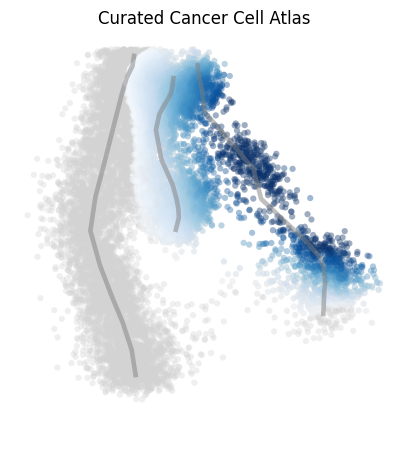

In [6]:
# plot landscape density
name, vmin = 'Data_Pancan_Average', .66
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 80, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs[name] >= vmin],
                'X_mesen', size = 80, alpha = .35,
                color = name, vmin = vmin, vmax = 'p95',
                cmap = 'Blues', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

ax.invert_yaxis()
ax.set_title('Curated Cancer Cell Atlas', size = 12)
ax.text(.5, -.05, ' ', ha = 'center', transform = ax.transAxes)
plt.savefig(os.path.join(pth_out, 'density.pdf'), bbox_inches = 'tight')